In [53]:
import re
import os 
import time
import numpy as np
import warnings
from datetime import datetime
import sys
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

sys.path.append("./")
warnings.filterwarnings("ignore")

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

"""
Author:     Christian Dewey
Run on:     26 June 23

CoreMS run script for correlating ICPMS, ESIMS data
"""



'\nAuthor:     Christian Dewey\nRun on:     26 June 23\n\nCoreMS run script for correlating ICPMS, ESIMS data\n'

In [2]:
def subset_icpdata(icp_data_file = None, heteroAtom = '127I', timerange = [0,1], offset = 0):

    icp_data = pd.read_csv(icp_data_file)
    try:
        etime = 'Time ' + heteroAtom
        icp_subset = icp_data[[heteroAtom,etime]]
    except:
        icp_data = pd.read_csv(icp_data_file, sep=';', skiprows=1)
    icp_data.dropna(inplace=True)

    timestart = timerange[0]
    timestop = timerange[1]
    element = heteroAtom
    etime = 'Time ' + heteroAtom
    icp_subset = icp_data[[element,etime]]
    icp_subset[etime] = (icp_subset[etime] + offset) / 60 
    icp_subset = icp_subset[icp_subset[etime].between(timestart,timestop)]

    return icp_subset


def get_eics(esi_file=None, assignments = None, timerange = None):
    esi_parser = rawFileReader.ImportMassSpectraThermoMSFileReader(esi_file)
    timestart = timerange[0]
    timestop = timerange[1]
    tic = esi_parser.get_tic(ms_type = 'MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})
    scans=tic_df[tic_df.time.between(timestart,timestop)].scan.tolist()
    AverageMS = esi_parser.get_average_mass_spectrum_by_scanlist(scans)

    EICdic = {}
    pbar = tqdm.tqdm(assignments['m/z'], desc="Getting EICs")
    
    for mz in pbar:   
        #   print('AverageMS mz:' + str(mz))
        EIC=esi_parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
        EICdic[mz]=EIC[0][mz]

    return EICdic, AverageMS


def interpolate(esi_file = None, icpsub=None, heteroAtom = '127I', timerange = [0,1]):
    ###Interpolate LC-ICPMS data to obtain times matching ESI data
    esi_parser = rawFileReader.ImportMassSpectraThermoMSFileReader(esi_file)
    timestart = timerange[0]
    timestop = timerange[1]
    etime = 'Time ' + heteroAtom
    tic = esi_parser.get_tic(ms_type = 'MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})
    
    times=tic_df[tic_df.time.between(timestart,timestop)].time.tolist()

    icpsubset2 = icpsub

    pbar = tqdm.tqdm(times, desc="Subsetting ICPMS data" )
    
    for i in pbar:
        icpsubset2.loc[-1]=['NaN',i]
        icpsubset2 = icpsubset2.sort_index().reset_index(drop=True)

    
    icpsubset2=icpsubset2.sort_values(by=etime)
    icpsubset2=icpsubset2.astype(float)
    icpsubset3=icpsubset2.interpolate()
    
    icp_interp=pd.DataFrame()
    pbar = tqdm.tqdm(times,desc="Interpolating ICPMS data")
    
    for i in pbar:
        icp_interp=icp_interp.append(icpsubset3[icpsubset3[etime]==i])
        
    return icp_interp


def correlate(icp_interp=None,EICdic=None,heteroAtom='127I',assignments = None, timerange=[0,1],threshold = 0.5):
    element = heteroAtom
    etime = 'Time ' + heteroAtom
    timestart = timerange[0]
    timestop = timerange[1]

    mscorr={}

    EICcurr=pd.DataFrame(index=icp_interp[etime],columns=['EIC',element])
    EICcurr[element]=icp_interp[element].array

    pbar = tqdm.tqdm(EICdic.keys(),desc="Running correlation")
    
    for mz in pbar:
        EIC=pd.DataFrame({'EIC':EICdic[mz].eic,'Time':EICdic[mz].time})
        EIC_sub=EIC[EIC['Time'].between(timestart,timestop)]

        EICcurr['EIC']=EIC_sub['EIC'].values

        corvalue=EICcurr.corr(method='pearson')
        mscorr[mz]=corvalue.EIC[element]**2
        
    mzs_corr = pd.DataFrame.from_dict(mscorr,orient='index',columns=['corr'])

    assignments=assignments.sort_values(by=['m/z'])

    holder = pd.DataFrame( index = range(len(assignments['m/z'])), columns = ['m/z', 'corr'])  #index = assignments['Index'],

    holder = np.zeros((len(assignments['m/z']),2))

    for mz,row in zip(assignments['m/z'], range(len(assignments['m/z']))):

        holder[row,1] = mzs_corr[mzs_corr.index == mz].iloc[0]
        holder[row,0] = mz

    pdholder = pd.DataFrame(holder, columns = ['m/z', 'corr'])

    assignments.insert(4,'corr',pdholder['corr'].values)

    assignments.insert(5,'m/z-2',pdholder['m/z'].values)

    match = re.findall(r'[A-Za-z]+|\d+', heteroAtom)
    heteroAtom = match[1]
    
    results=assignments[assignments['corr']>threshold].filter(['m/z','Calibrated m/z','corr','Peak Height','Confidence Score','m/z Error (ppm)','Molecular Formula',heteroAtom])

    bestresults=results[(results[heteroAtom]>=1)]

    return results, bestresults


In [83]:
def plot_EIC_ICPMS(eic,mz,icpmsfile,element, trange, offset, mf = None, err = None, ax = None):

    icp_data = pd.read_csv(icpmsfile)
    try:
        etime = 'Time ' + element
        icp_subset = icp_data[[element,etime]]
    except:
        icp_data = pd.read_csv(icpmsfile, sep=';', skiprows=1)
    icp_data.dropna(inplace=True)
    if ax == None:
        _, ax = plt.subplots()

    icp_data.dropna(inplace=True)

    etime = 'Time ' + element
    icp_subset = icp_data[[element,etime]]
    icp_subset[etime] = (icp_subset[etime])
    ax.plot((icp_subset[etime] + offset)/60, icp_subset[element]/max(icp_subset[element]), label=element)
    maxy = max(eic.eic)
    ydata = [e / maxy for e in eic.eic]

    if pd.isna(mf):
        mf = 'Unassigned'
        mflbl = '%.4f'%mz + '\n' + '%s' %mf 

    else:
        mflbl = 'm/z:     %.4f'%mz + '\n' + 'MF:      %s' %mf + '\n' + 'error:   %.2f ppm'%err 
    ax.plot(eic.time, ydata, label=mflbl)
      
    ax.set_ylabel('Normalized Intensity')
    ax.set_xlabel('Time (min)')
    ax.set_ylim(bottom = 0)
    ax.legend(frameon = False, loc = 'upper left', fontsize = 6)
    ax.set_xlim(trange[0],trange[1])
    return ax
    


In [112]:
def plot_ICPMS(icpmsfile,element, trange, offset, ax = None):

    icp_data = pd.read_csv(icpmsfile)
    try:
        etime = 'Time ' + element
        icp_subset = icp_data[[element,etime]]
    except:
        icp_data = pd.read_csv(icpmsfile, sep=';', skiprows=1)
    icp_data.dropna(inplace=True)
    if ax == None:
        _, ax = plt.subplots()

    icp_data.dropna(inplace=True)

    etime = 'Time ' + element
    icp_subset = icp_data[[element,etime]]
    icp_subset[etime] = (icp_subset[etime])
    ax.plot((icp_subset[etime] + offset)/60, icp_subset[element]/max(icp_subset[element]), label=element)

      
    ax.set_ylabel('ICP-MS Intensity (cps)')
    ax.set_xlabel('Time (min)')
    ax.set_ylim(bottom = 0)
    ax.legend(frameon = False, loc = 'upper left', fontsize = 6)
    ax.set_xlim(trange[0],trange[1])
    return ax

In [107]:
data_dir = '/Users/christiandewey/data/Syn-cultures-May_June-2023/7803/'

icpmsfile = data_dir + 'Syn_7803.csv'

interval = 2

'''#peak A
time_min = 12
time_max = 16

#peak B
time_min = 37
time_max = 41

#peak C
time_min = 44
time_max = 46

#peak D
time_min = 46
time_max = 48'''

#peak E
time_min = 48
time_max = 52

In [108]:
assignment_results = pd.read_csv(data_dir + '7803_peakE_neg_assignments.csv')
esifile = data_dir + 'Syn7803_neg.raw'


icp_subset = subset_icpdata(icp_data_file = icpmsfile, heteroAtom = '127I', timerange = [time_min,time_max], offset = -42)

icp_interp = interpolate(esi_file = esifile, icpsub=icp_subset, heteroAtom = '127I', timerange =  [time_min,time_max])


Interpolating ICPMS data: 100%|██████████| 138/138 [00:00<00:00, 2992.11it/s]


In [109]:
eic_dict, mass_spectrum = get_eics(esi_file=esifile, assignments = assignment_results, timerange = [time_min,time_max])

with open(data_dir + "7803_peakE_eics.pkl", 'wb') as fp:
    pickle.dump(eic_dict, fp)


10 peaks with charge of -2 based on 13C
289 peaks with charge of -1 based on 13C
299 peaks assigned default charge (--1)


Getting EICs: 100%|██████████| 1871/1871 [07:15<00:00,  4.30it/s]


In [17]:
with open(data_dir + 'eics.pkl', 'rb') as handle:
    eic_dict = pickle.load(handle)

In [110]:
results, bestresults = correlate(icp_interp=icp_interp, EICdic=eic_dict,heteroAtom='127I',assignments = assignment_results, timerange=[time_min,time_max],threshold = 0.5)

print(bestresults)

results.to_csv(data_dir+'7803_peakE_correlation_results.csv')

Running correlation: 100%|██████████| 1859/1859 [00:03<00:00, 586.93it/s]


Empty DataFrame
Columns: [m/z, Calibrated m/z, corr, Peak Height, Confidence Score, m/z Error (ppm), Molecular Formula, I]
Index: []


351.1583798739969
361.1641307527452
361.1644310923415
394.98674632388713
396.9848158918065
439.2110187093941
469.2456733720663
523.2692544853517


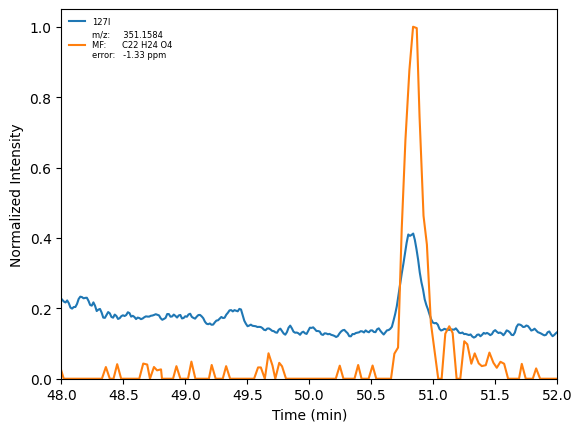

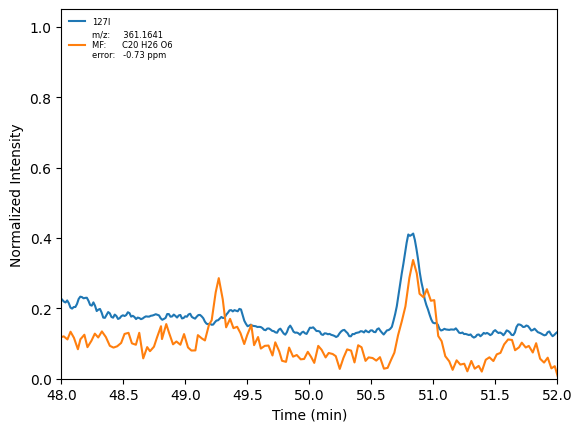

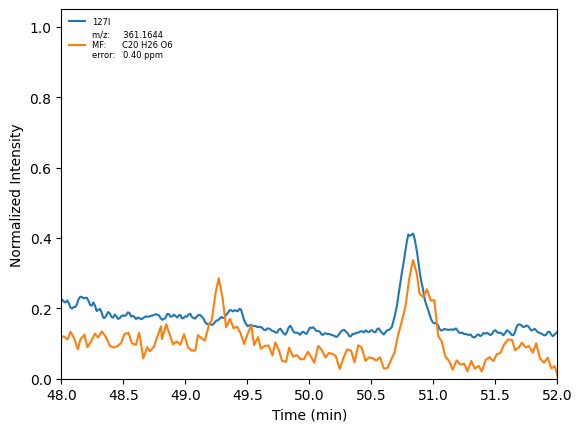

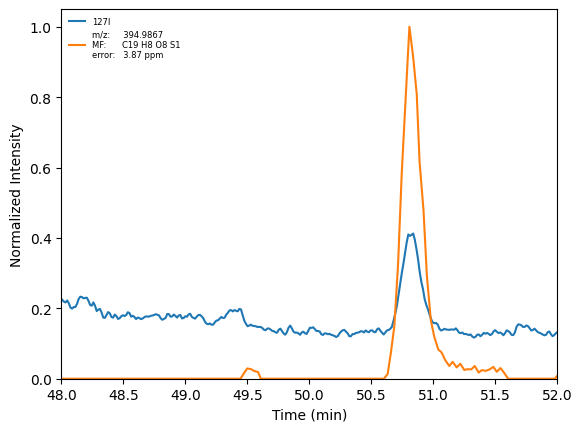

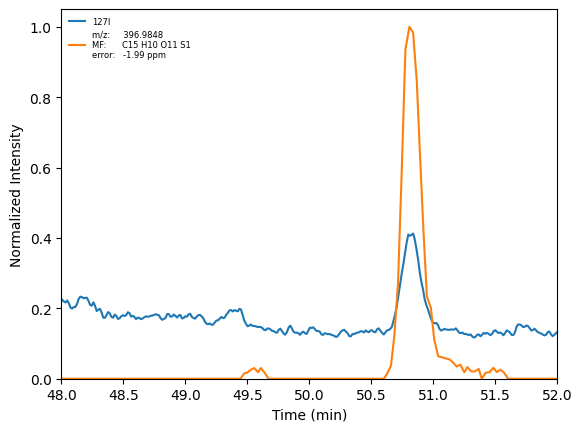

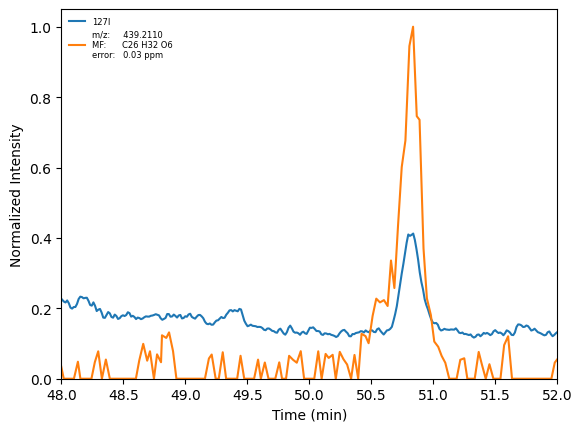

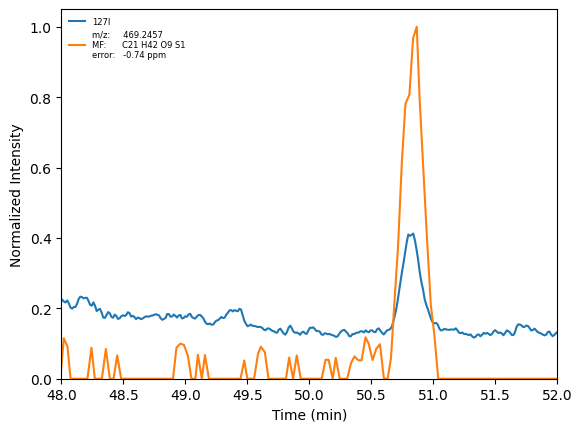

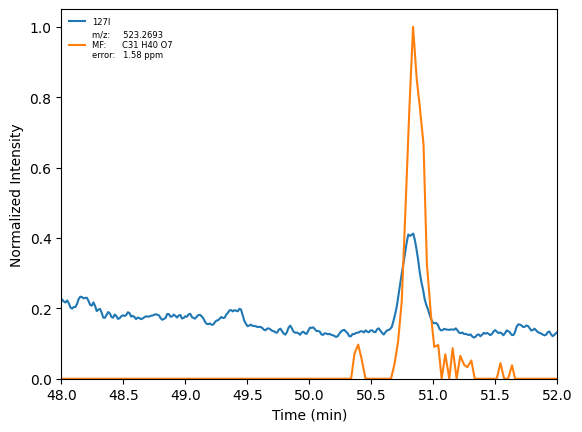

In [111]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_file_name = data_dir + '7803_peakE_46-48min.pdf' 

with PdfPages(pdf_file_name) as pdf:

    for mz, mf, err, corr in zip(results['m/z'], results['Molecular Formula'], results['m/z Error (ppm)'] ,results['corr']):
        
        if corr >.3:
            print(mz)
            eic = eic_dict[mz]

            fig, ax = plt.subplots()

            timerange = [time_min,time_max] #list(range(time_min,time_max,interval))

            ax = plot_EIC_ICPMS(eic,mz,icpmsfile,'127I', timerange, offset = -42, mf=mf, err = err, ax = ax)

            # save the current figure at a new page in pdf_file_name
            pdf.savefig()   

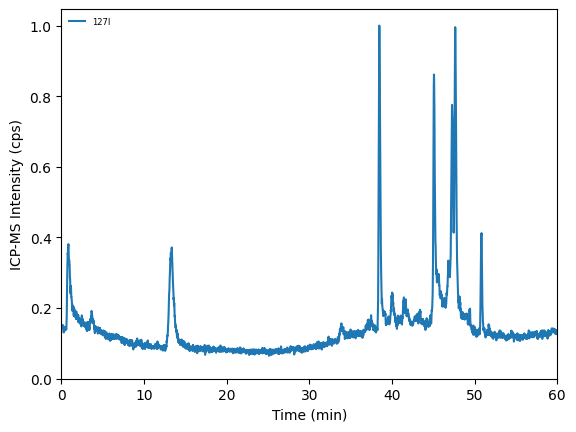

In [113]:
pdf_file_name = data_dir + '7803_ICPMS.pdf' 

with PdfPages(pdf_file_name) as pdf:

    eic = eic_dict[mz]

    fig, ax = plt.subplots()

    timerange = [0,60] #list(range(time_min,time_max,interval))

    ax = plot_ICPMS(icpmsfile,'127I', timerange, offset = -42, ax = ax)

    # save the current figure at a new page in pdf_file_name
    pdf.savefig()   

237.14879972306045


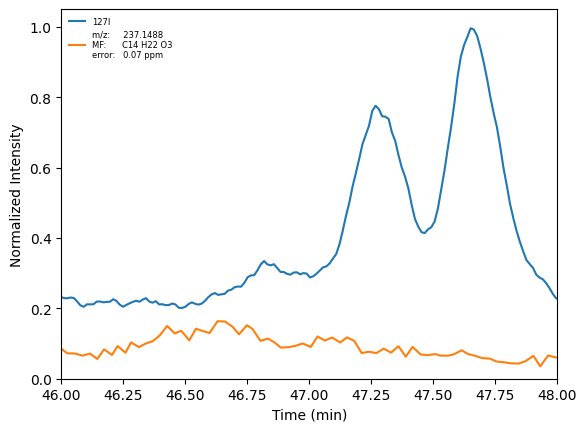

238.15209998774105


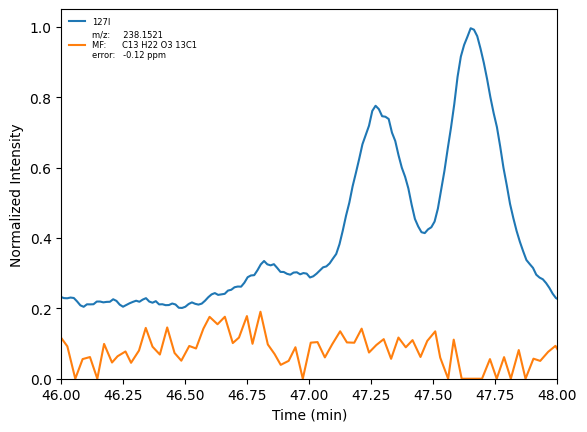

271.1079747636247


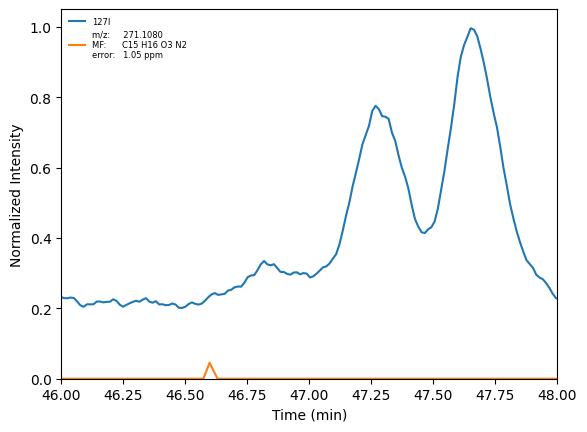

274.12695655220176


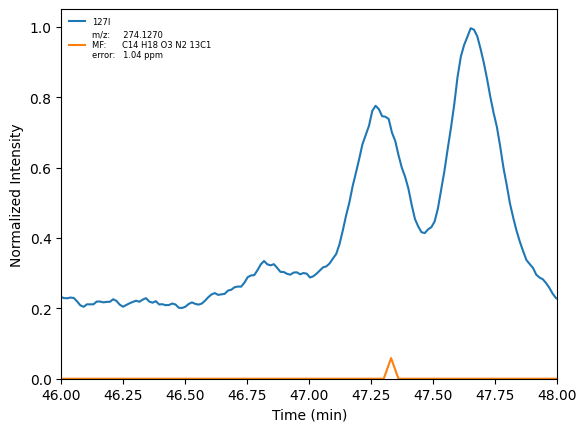

339.04322339451045


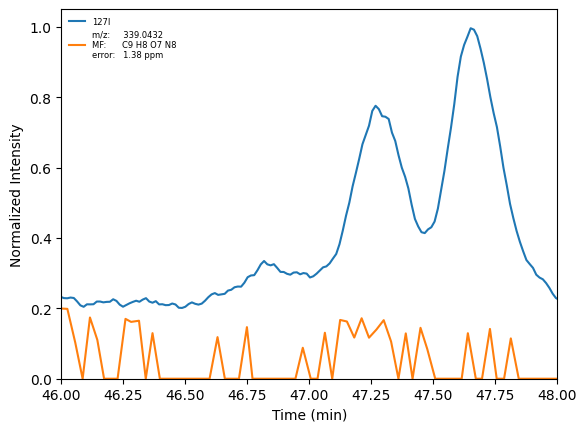

343.1565710195248


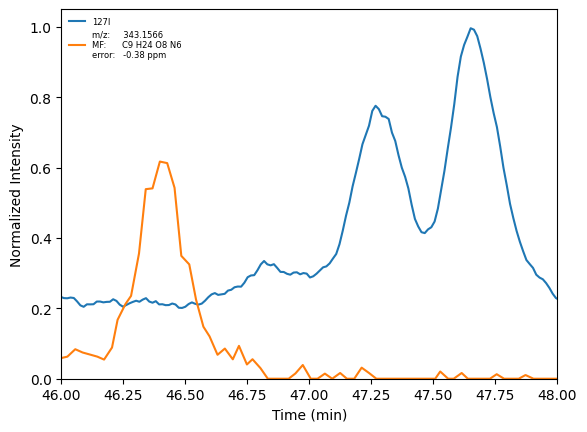

367.1567038309759


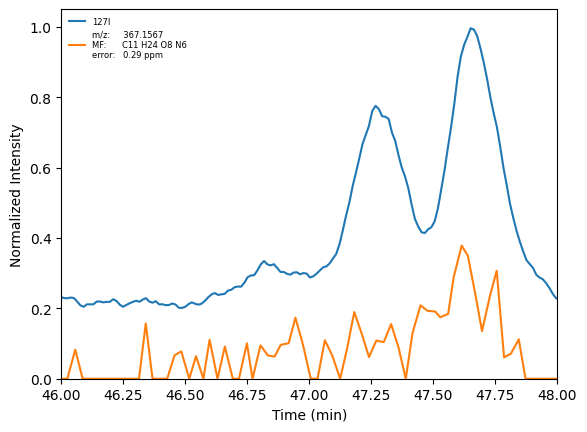

391.0380885404548


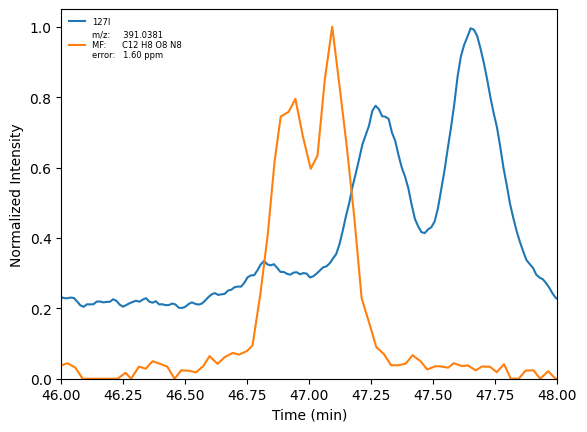

417.0720163708044


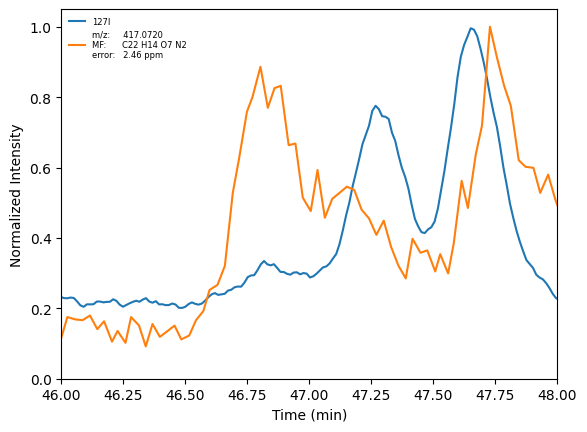

445.242524322621


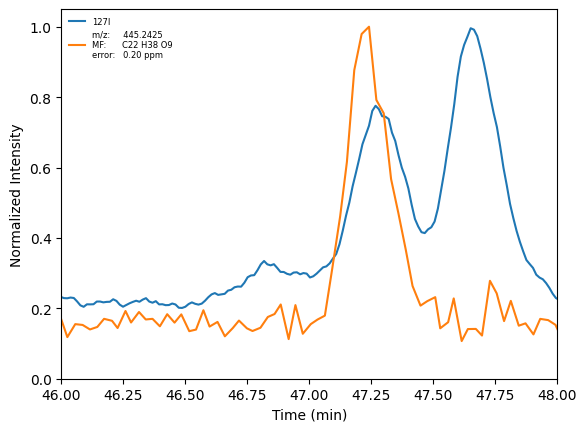

455.08726541072895


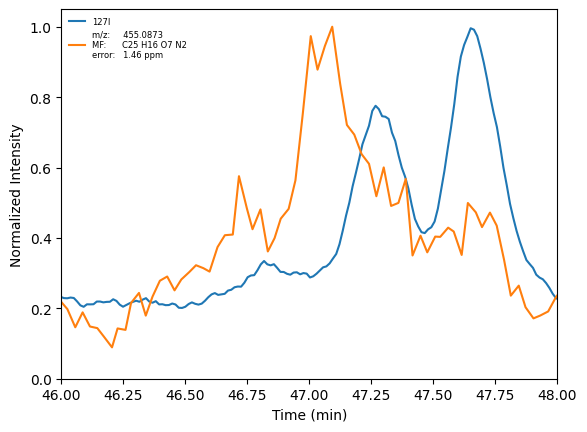

463.2530178106912


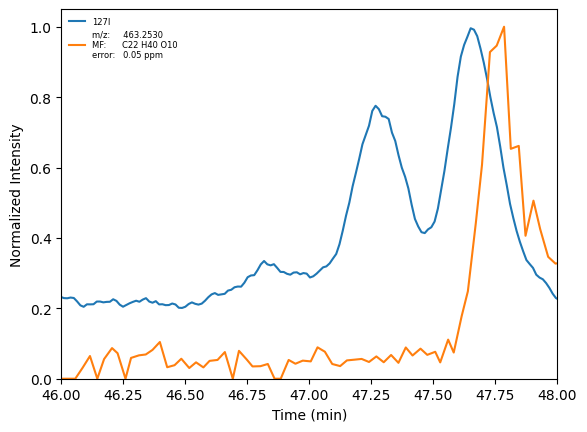

525.0901545285511


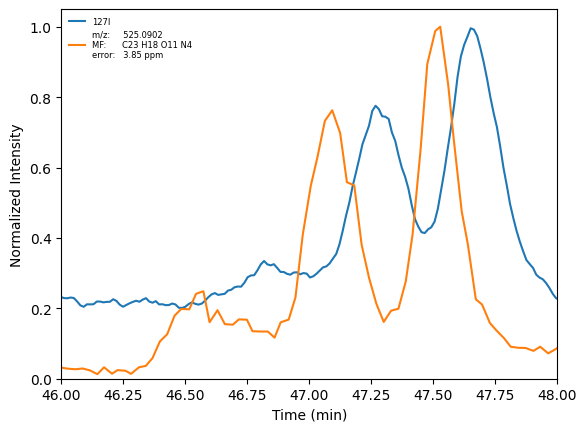

617.1163333472771


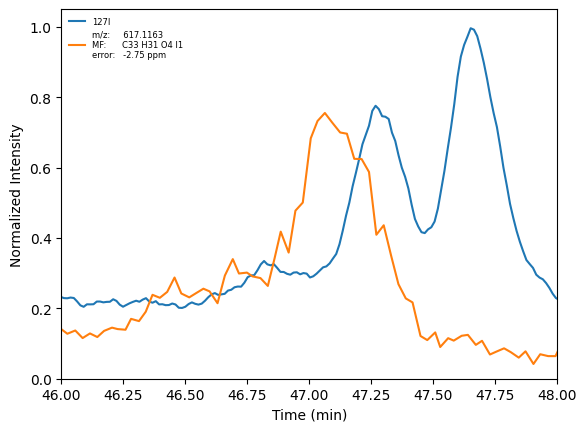

618.1197029069543


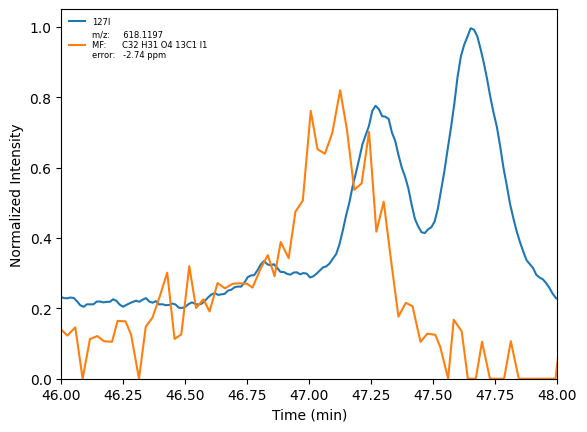

618.1197029069543


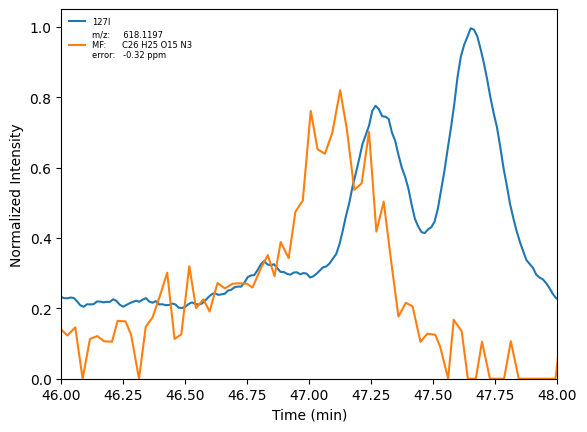

In [101]:
for mz, mf, err, corr in zip(results['m/z'], results['Molecular Formula'], results['m/z Error (ppm)'] ,results['corr']):
    if corr >.4:
        print(mz)
        eic = eic_dict[mz]

        fig, ax = plt.subplots()

        timerange = [time_min,time_max] #list(range(time_min,time_max,interval))

        ax = plot_EIC_ICPMS(eic,mz,icpmsfile,'127I', [46,48], offset = -42, mf=mf, err = err, ax = ax)

        plt.show()


In [ ]:
data_dir = '/Users/christiandewey/data/Syn-cultures-May_June-2023/7803/'
icpmsfile = data_dir + 'Syn_7803.csv'

assignment_results = pd.read_csv(data_dir + 'b12_assignment.csv')
esifile = data_dir + 'Syn7803_pos.raw'
time_min = 34
time_max = 36

icp_subset = subset_icpdata(icp_data_file = icpmsfile, heteroAtom = '59Co', timerange = [time_min,time_max], offset = -42)

icp_interp = interpolate(esi_file = esifile, icpsub=icp_subset, heteroAtom = '59Co', timerange =  [time_min,time_max])


In [ ]:
# extract eics
eic_dict, mass_spectrum = get_eics(esi_file=esifile, assignments = assignment_results, timerange = [time_min,time_max])

with open(data_dir + "b12_eics.pkl", 'wb') as fp:
    pickle.dump(eic_dict, fp)
    print("EIC dictionary saved to b12_eics.pkl")




In [16]:
with open(data_dir + 'b12_eics.pkl', 'rb') as handle:
    eic_dict = pickle.load(handle)

In [ ]:
#eic_dict3 = pickle.load(data_dir + "b12_eics.pkl")


results, bestresults = correlate(icp_interp=icp_interp, EICdic=eic_dict,heteroAtom='59Co',assignments = assignment_results, timerange=[time_min,time_max],threshold = 0.5)

print(bestresults)

results.to_csv(data_dir+'b12_correlation_results.csv')

664.7870426102494 nan nan


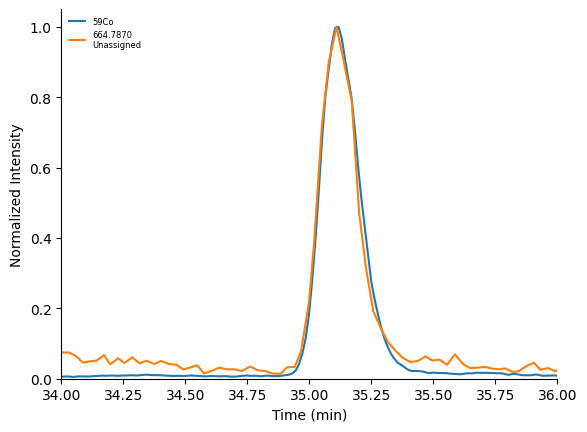

665.2893618805168 C61 H86 O14 N14 P1 Co1 3.846895173382885


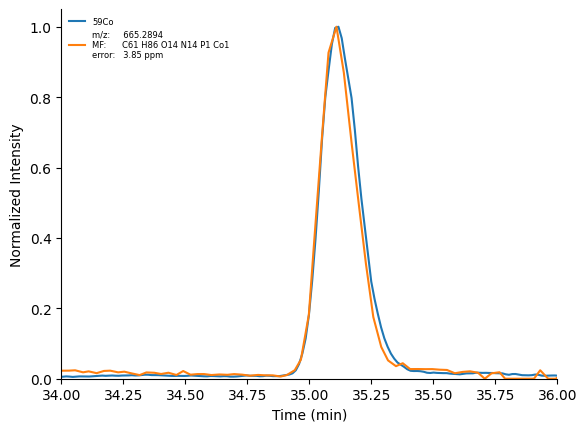

665.7921599750052 nan nan


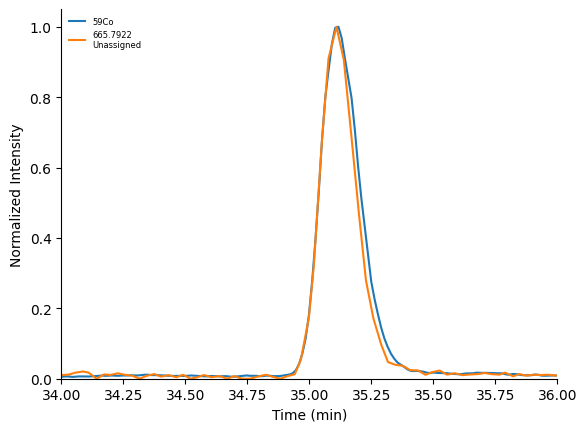

678.2924428440564 C63 H88 O14 N14 P1 Co1 -3.6186806198081816


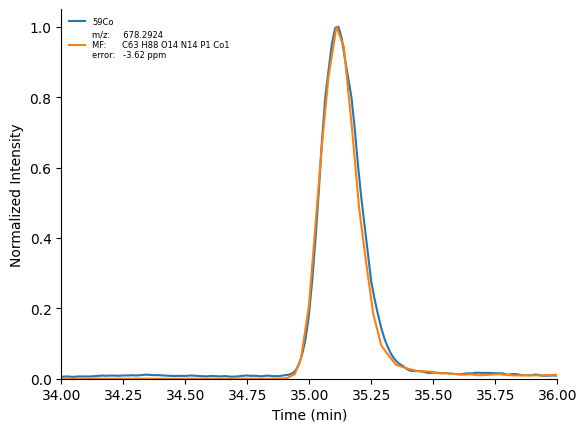

678.7927761504994 C63 H88 O14 N13 P1 Co1 15N1 -0.9564662161035044


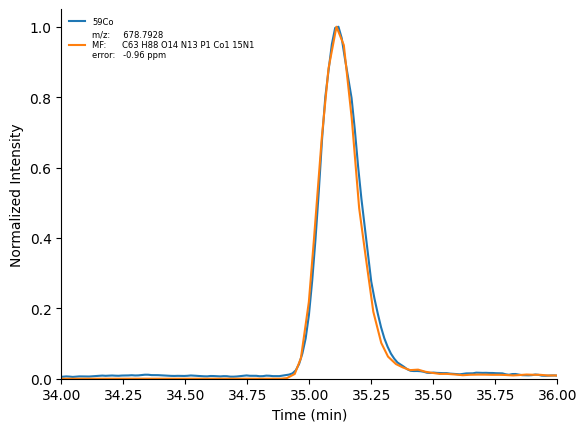

679.2936470199644 C62 H88 O14 N13 13C1 P1 Co1 15N1 -2.158711467123521


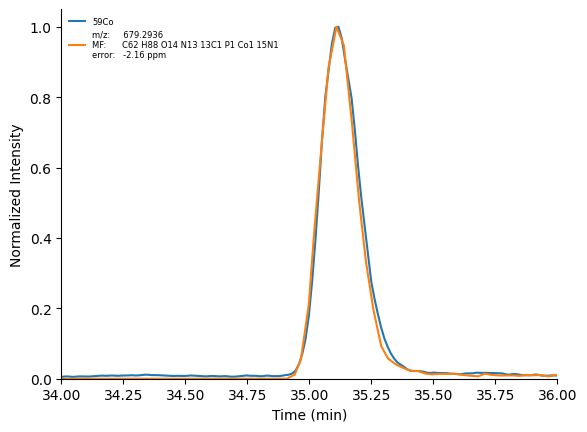

679.2936470199644 C63 H88 O13 N14 P1 Co1 18O1 -4.996408075972617


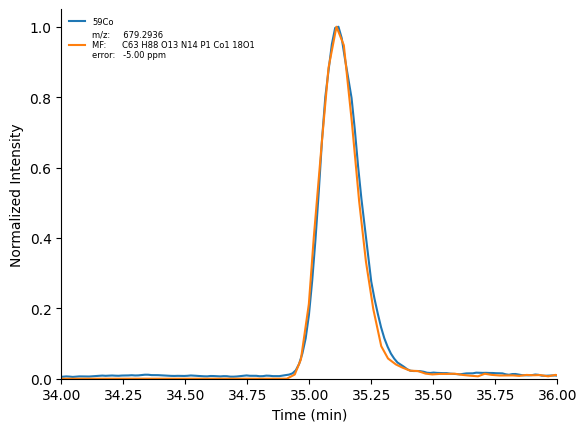

679.7951978602109 C61 H88 O14 N13 13C2 P1 Co1 15N1 -2.358963738444441


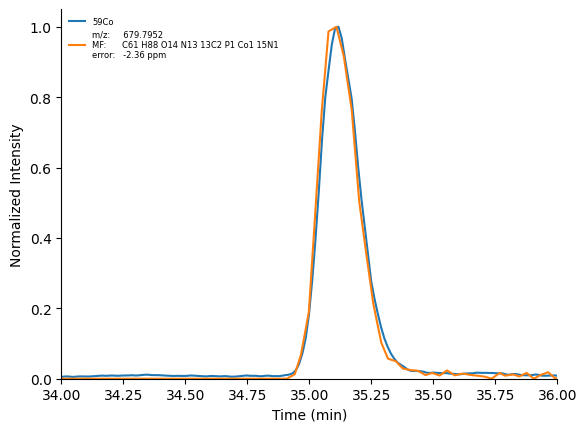

680.7986757695485 nan nan


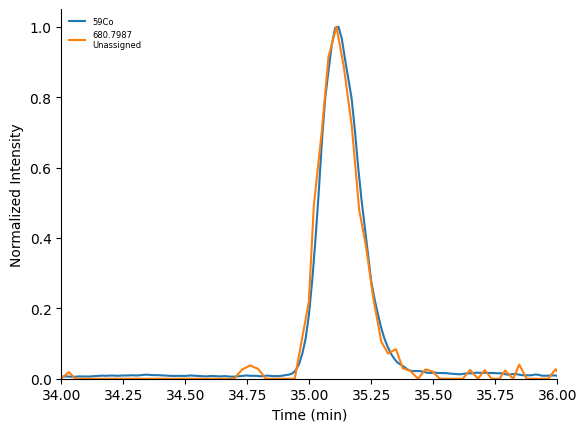

681.7887157181182 nan nan


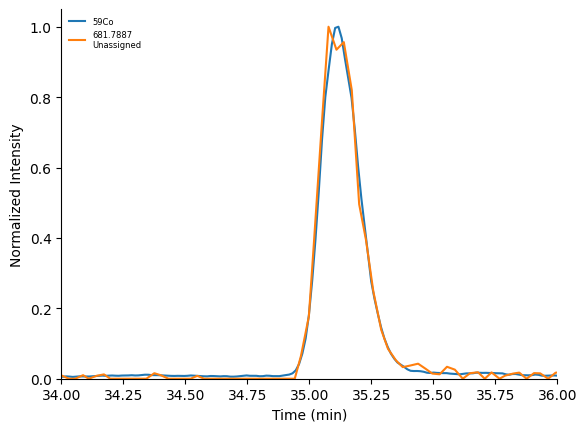

682.290306628677 C66 H88 O14 N12 P1 Co1 -2.347520932945274


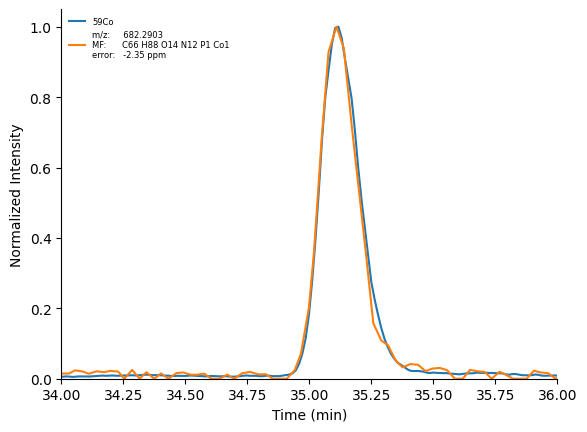

682.7922801108077 C65 H88 O14 N12 13C1 P1 Co1 -1.927907290206589


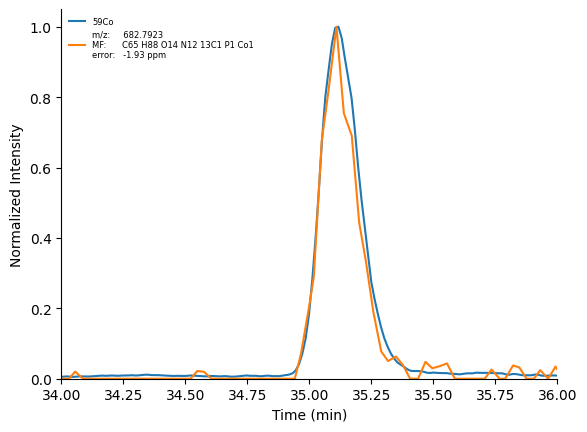

689.283587422157 nan nan


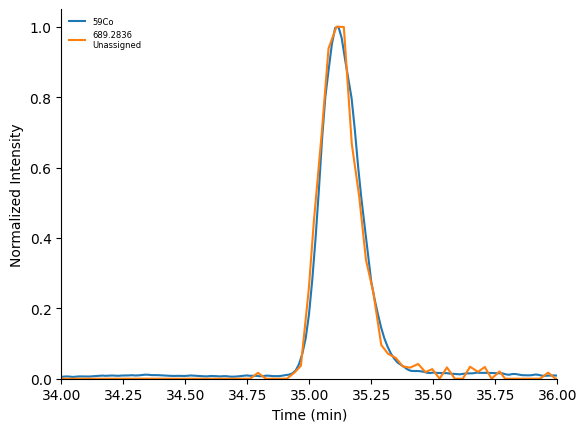

689.7844603207161 nan nan


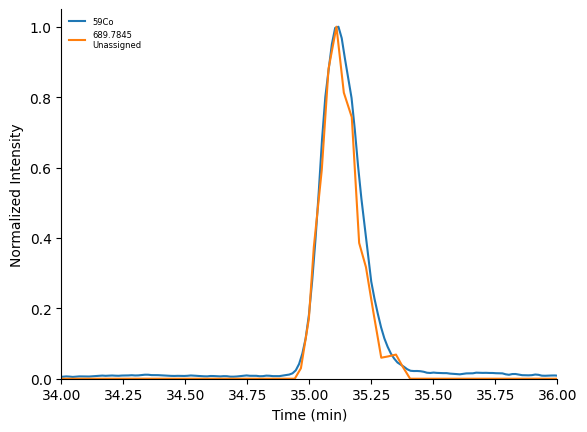

In [54]:
for mz, mf, err, corr in zip(results['m/z'], results['Molecular Formula'], results['m/z Error (ppm)'] ,results['corr']):
    if corr > 0.98:
        print(mz, mf, err)
        eic = eic_dict[mz]

        fig, ax = plt.subplots()

        timerange = [time_min,time_max] #list(range(time_min,time_max,interval))

        ax = plot_EIC_ICPMS(eic,mz,icpmsfile,'59Co', timerange, offset = -42, mf=mf, err = err, ax = ax)

        sns.despine()
        plt.show()  #

    

C63 H88 O14 N14 P1 Co1


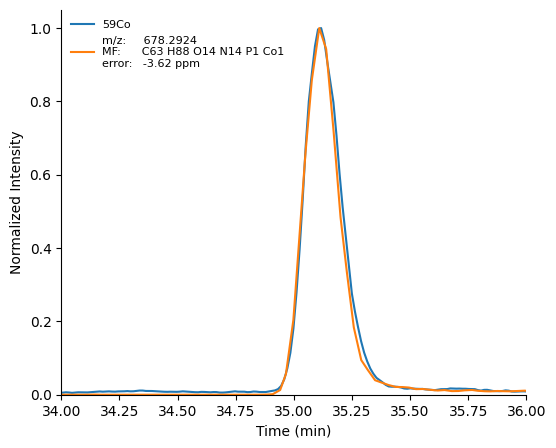

In [70]:
mz = 678.2924428440564

sub = results[results['m/z'] == mz]

mf = sub['Molecular Formula'].values[0]
err = sub['m/z Error (ppm)'].values
corr = sub['corr'].values

eic = eic_dict[mz]

print(mf)
fig, ax = plt.subplots(figsize = (6,5))

timerange = [time_min,time_max] 

ax = plot_EIC_ICPMS(eic,mz,icpmsfile,'59Co', timerange, offset = -42, mf=mf, err = err, ax = ax)

sns.despine()
plt.savefig(data_dir + 'b12_eic_icpms.pdf')
